# PGI applied to the Bookpurnong RESOLVE dataset for saline water zone characterization

_This notebook was adapted from_ https://github.com/simpeg/simpegEM1D/

### This notebook reproduces the FDEM field example from Astic & Oldenburg 2019.

This example illustrates an application of the PGI approach on a field frequency-domain EM dataset, in conjunction with a structurally constraining regularization, without using extensive geological or petrophysical information. We demonstrate how to use this framework to test hypothesis, such as a recovering a specific number of distinct units, and to build confidence, or doubts, in geological features displayed by the inversions.

For that purpose, we start by demonstrating that starting from different initial model leads to different near-surface models in the Tikhonov approach, thus different possible interpretations.  We show that in the PGI case, by only assuming an expected number of distinct units, either initial model leads to get almost the same final recovered models at the near-surface, with consistent learned reference models and petrophysical distributions. The PGI approach also removes features that were not required by the data, which build confidences in the remaining ones for the interpreter.

In [1]:
import SimPEG
from SimPEG import Mesh, Maps, Utils
import numpy as np
import copy
import h5py
import os
from scipy.constants import mu_0
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
import seaborn
seaborn.set()
from matplotlib.colors import LogNorm
from simpegEM1D import (
    GlobalEM1DProblemFD, GlobalEM1DSurveyFD, 
    get_vertical_discretization_frequency,
    get_2d_mesh, LateralConstraint,
    set_mesh_1d

)
from SimPEG import (
    Regularization, Directives, Inversion, InvProblem, Optimization, DataMisfit, Utils
)
from pymatsolver import PardisoSolver
from PGI_FDEM_example_Utils import download_and_unzip_data, plot2Ddata, plot2Ddata_categorical, order_clusters_GM_mean

%matplotlib inline

np.random.seed(518936)

# Get the data

In [2]:
# download the data
url = "https://storage.googleapis.com/simpeg/bookpurnong/bookpurnong_inversion.tar.gz"
downloads, directory = download_and_unzip_data(url)

# Load resolve data
resolve = h5py.File(
    os.path.sep.join([directory, "booky_resolve.hdf5"]),
    "r"
)

river_path = resolve["river_path"].value    # River path
nskip = 1
nSounding = resolve["data"][::nskip, :].shape[0]    # the # of soundings

# Bird height from surface
b_height_resolve = (resolve["src_elevation"])[::nskip]

# fetch the frequencies we are considering
cpi_inds = [0, 2, 6, 8, 10]  # Indices for HCP in-phase
cpq_inds = [1, 3, 7, 9, 11]  # Indices for HCP quadrature
frequency_cp = resolve["frequency_cp"].value
xy = (resolve["xy"].value)[::nskip, :]
line = resolve['line'][::nskip]
data_cpi = resolve["data"][::nskip, cpi_inds].astype(float)
data_cpq = resolve["data"][::nskip, cpq_inds].astype(float)

file already exists, new file is called C:\Users\Thibaut Astic\Documents\GITHUB\Astic-2019-PGI\notebooks\bookpurnong_inversion.tar.gz
   saved to: C:\Users\Thibaut Astic\Documents\GITHUB\Astic-2019-PGI\notebooks\bookpurnong_inversion.tar.gz
Download completed!


C:\ProgramData\Anaconda3\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


# Mesh and Survey objects

In [3]:
#create the 1D mesh
frequency = np.array([382, 1822, 7970, 35920, 130100], dtype=float)
hz = get_vertical_discretization_frequency(frequency, sigma_background=1./50)
mesh_1d = set_mesh_1d(hz)

# survey parameters
rxOffset = 7.86  # tx-rx separation
bp = -1./(4*np.pi*rxOffset**3)  # primary magnetic field

# Create the survey object
n_sounding = xy.shape[0]
b_height_resolve = resolve["src_elevation"].value[::nskip]
topo_resolve = resolve["ground_elevation"].value[::nskip]

x = xy[:,0]
y = xy[:,1]
z = topo_resolve + b_height_resolve
rx_locations = np.c_[x, y, z]
src_locations = np.c_[x, y, z]
topo = np.c_[x, y, topo_resolve].astype(float)

mapping = Maps.ExpMap(nP=int(n_sounding*hz.size))
survey = GlobalEM1DSurveyFD(
    rx_locations = rx_locations,
    src_locations = src_locations,    
    frequency = frequency,
    offset = np.ones_like(frequency) * 7.86,
    src_type = "VMD",
    rx_type = "Hz",
    field_type = 'secondary',
    topo = topo    
)

# Set the physics problem
prob = GlobalEM1DProblemFD(
    [], sigmaMap=mapping, hz=hz, parallel=True, n_cpu=10,
    Solver=PardisoSolver
)
prob.pair(survey)

# initial model
m0 = np.ones(mapping.nP) * np.log(1./100.)
pred = survey.dpred(m0)

# Unit conversion from ppm to A\m
DOBS = np.empty((prob.n_sounding, 2, survey.n_frequency))
DPRED = pred.reshape((prob.n_sounding, 2, survey.n_frequency))
for i_freq in range(frequency_cp.size):
    DOBS[:,0,i_freq] = data_cpi[:, i_freq]
    DOBS[:,1,i_freq] = data_cpq[:, i_freq]    
DOBS *= bp * 1e-6
dobs = DOBS.flatten()

C:\ProgramData\Anaconda3\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


>> Use multiprocessing for parallelization
>> n_cpu: 10


In [4]:
# Create the 2D mesh
mesh_reg = get_2d_mesh(n_sounding, hz)
# Now we can create the regularization using the 2D mesh
reg = LateralConstraint(mesh_reg, mapping=Maps.IdentityMap(nP=mesh_reg.nC))
tri = reg.get_grad_horizontal(xy, hz)

-5.269895526866835
-2.4666441137199233


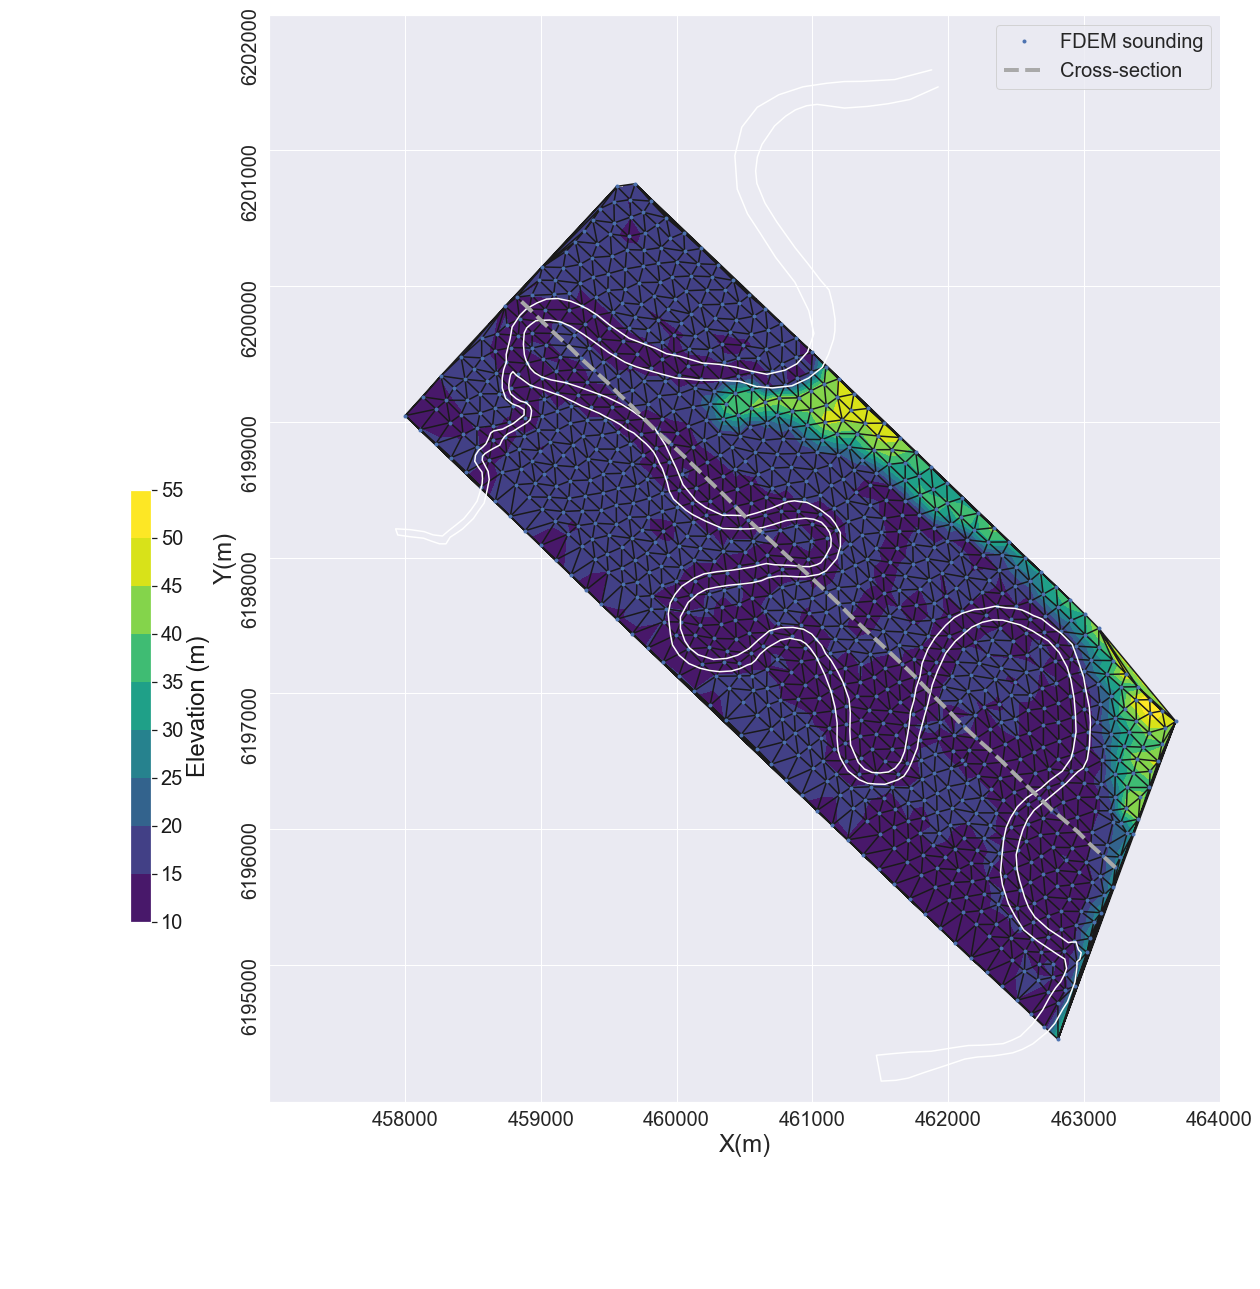

In [5]:
# Visualize the topography, 2D mesh, sounding locations, cross-section location and river path
uniq_line = np.unique(line)
depth = -mesh_1d.gridN[:-1]
xyz = np.empty((hz.size, xy.shape[0], 3), order='F')
for i_xy in range(xy.shape[0]):
    z = - mesh_1d.vectorCCx + topo[i_xy, 2]
    x = np.ones_like(z) * xy[i_xy,0]
    y = np.ones_like(z) * xy[i_xy,1]
    xyz[:, i_xy, :] = np.c_[x, y, z]

xmin, xmax = xy[:,0].min(), xy[:,0].max()
ymin, ymax = xy[:,1].min(), xy[:,1].max()
zmin, zmax = topo[:,2].min() + depth.min(), topo[:,2].max()

iz = 2
i_line = 11
ind_line = line == uniq_line[i_line]
xz = xyz[:, ind_line, :][:,:,[0,2]].reshape((int(hz.size*ind_line.sum()), 2), order='F')
print (depth[iz])

iz = 1
i_line = 11
ind_line = line == uniq_line[i_line]
xz = xyz[:, ind_line, :][:,:,[0,2]].reshape((int(hz.size*ind_line.sum()), 2), order='F')
print (depth[iz])
temp = topo
fig,ax = plt.subplots(1,1,figsize=(20, 20))
nx, ny = 500,500
out = plot2Ddata(temp[:,:2], temp[:,2], scale='linear',ax=ax,
                      ncontour=7,
                         nx=nx,
                        ny=ny,
                 clim=[10,50],
                      levelOpts={'colors':'k','linewidths':1, 'linestyles':'dotted'},
                      contourOpts={'cmap':'viridis','alpha':1.
                                  })

plt.yticks(rotation=90)
plt.gca().tick_params(labelsize=20)
plt.gca().yaxis.set_ticks(np.linspace(6195000,6202000,8))
plt.gca().xaxis.set_ticks(np.linspace(458000,464000,7))
plt.gca().set_xlabel('X(m)',fontsize=24)
plt.gca().set_ylabel('Y(m)',fontsize=24)
plt.gca().set_ylim([6193990,6202000])
plt.gca().set_xlim([457000,464011])
plt.gca().triplot(xy[:,0], xy[:,1], tri.simplices,color='k', label="")
plt.gca().plot(xy[:,0], xy[:,1], '.',label="FDEM sounding")
plt.gca().plot(river_path[:,0], river_path[:,1], 'w-')
plt.gca().plot(xy[ind_line,0],xy[ind_line,1], linestyle='--',color='darkgray', linewidth=4.,label='Cross-section')
plt.gca().legend(fontsize=20)

cbaxes = fig.add_axes([0.0, 0.0, 0.1, 0.8])  # This is the position for the colorbar
cbaxes.get_xaxis().set_visible(False)
cbaxes.get_yaxis().set_visible(False)
cbaxes.axis('off')
cb = plt.colorbar(out[0],ax=cbaxes, format='%.f')#"$10^{%.1f}$")
cb.set_ticks(np.r_[np.linspace(10,50,9),54.87])#,color='w')
cb.set_label('Elevation (m)',fontsize=24,color='k')
cb.ax.tick_params(labelsize=20,colors='k')

plt.show()


Text(0.5, 1.0, '1D Mesh')

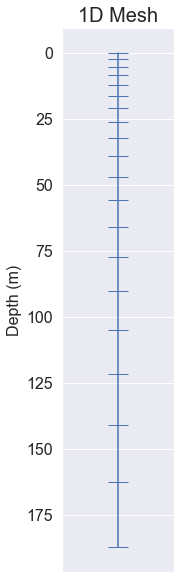

In [6]:
# Visualize the 1D mesh
fig, ax = plt.subplots(1,1,figsize=(2,10))
ax.plot(np.ones(20),np.unique(mesh_1d.vectorNx),'_-',ms=20)
ax.invert_yaxis()
ax.set_xticks([])
ax.tick_params(labelsize=16)
ax.set_ylabel('Depth (m)',fontsize=16)
ax.set_title('1D Mesh',fontsize=20)
#fig.savefig("Booky_1DMesh_HighRes.png", dpi=600, bbox_inches='tight', pad_inches=0.1)
#fig.savefig("Booky_1DMesh_LowRes.png", dpi=72, bbox_inches='tight', pad_inches=0.1)

# Tikhonov Inversion, starting from a resistive background

In [7]:
# Set geophysical uncertainty
std = 0.1
floor = abs(20 * bp * 1e-6)   # floor of 20ppm
survey.std=std
survey.eps=floor
uncert = std*abs(dobs)+floor
survey.dobs = dobs

# Set data misfit object 
m0 = np.ones(mesh_reg.nC) * np.log(1e-2)
dmisfit = DataMisfit.l2_DataMisfit(survey,std=std,eps=floor)
dmisfit.W = 1./uncert

# Set the regularization object
regmap = Maps.IdentityMap(mesh_reg)
reg = LateralConstraint(
    mesh_reg, mapping=Maps.IdentityMap(nP=mesh_reg.nC),
    alpha_s=1.,
    alpha_x = 10.,
    alpha_y = 1.,        
)
tri = reg.get_grad_horizontal(xy, hz)

# Optimization
opt = Optimization.ProjectedGNCG(
    maxIter=20,
    maxIterLS=20, maxIterCG=20, tolCG=1e-1
)
opt.LSshorten = 0.5
opt.remember('xc')

# Set the inverse problem
invProb = InvProblem.BaseInvProblem(dmisfit, reg, opt)
invProb.beta=1e-2
prob.counter = opt.counter = Utils.Counter()

# Inversion directives
beta = Directives.BetaSchedule(coolingFactor=5, coolingRate=3)
target = Directives.TargetMisfit()
inv = Inversion.BaseInversion(invProb, directiveList=[
                                                    beta,
                                                    target,
])

# Run!
mopt = inv.run(m0)

SimPEG.InvProblem will set Regularization.mref to m0.

                SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                ***Done using same Solver and solverOpts as the problem***
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  1.00e-02  1.91e+05  0.00e+00  1.91e+05    1.47e+03      0              
   1  1.00e-02  4.38e+04  4.85e+05  4.87e+04    5.18e+02      0              
   2  1.00e-02  3.82e+04  7.43e+05  4.56e+04    6.39e+02      0   Skip BFGS  
   3  2.00e-03  1.59e+04  6.13e+05  1.72e+04    6.19e+02      0              
   4  2.00e-03  7.51e+03  7.72e+05  9.05e+03    2.81e+02      0              
------------------------- STOP! -------------------------
1 : |fc-fOld| = 0.0000e+00 <= tolF*(1+|f0|) = 1.9085e+04
0 : |

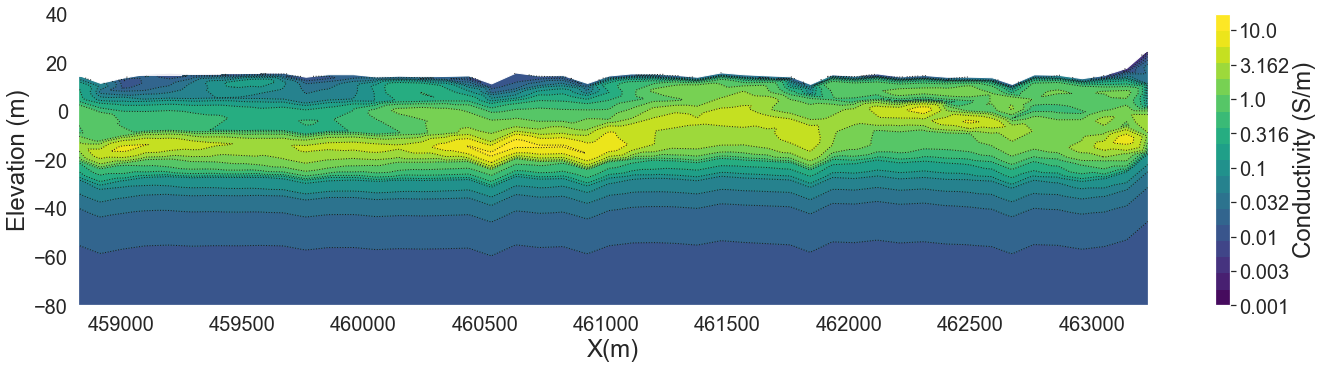

In [8]:
# Plot the crosssection of Tikhonov recovered model starting with a resistive background

# Create mask to mask air area
nx,ny,nz=500,500,500
xmin0, xmax0 = xz[:, 0].min(), xz[:, 0].max()
zmin0, zmax0 = xz[:, 1].min(), xz[:, 1].max()
xgrid = np.linspace(xmin0, xmax0, nx)
zgrid = np.linspace(zmin0, zmax0, nz)
X, Z = np.meshgrid(xgrid, zgrid)
xz0 = np.c_[X.flatten(), Z.flatten()]
Ftopo = interp1d(topo[ind_line, 0], topo[ind_line, 2])
topoline = Ftopo(X.flatten())
mask = xz0[:,1]>= topoline

fig,ax = plt.subplots(1,1,figsize=(20,5))
moptm = mopt.reshape((hz.size, n_sounding), order='F')
mopt_xz = Utils.mkvc(moptm[:,ind_line])
sigma = mapping * mopt
Sigma = sigma.reshape((hz.size, n_sounding), order='F')
sigma_xz = Utils.mkvc(Sigma[:,ind_line])

mm = plot2Ddata(
    xz, sigma_xz, scale='log',ax=ax,
    level=True, 
    ncontour=16,
    levelOpts={'colors':'k','linewidths':1, 'linestyles':'dotted'},
    clim=10.**(np.r_[-3,1]),
    mask=mask,
    nx=nx,
    ny=ny,
    contourOpts={'cmap':'viridis'},
    dataloc=False
)

plt.fill_between(topo[ind_line, 0], topo[ind_line, 2], topo[ind_line, 1]*0. + zmax, color='w')
plt.gca().set_aspect(10)
plt.gca().set_ylim([-80,40])
cb = plt.colorbar(mm[0], format='%.1e')
cb.set_ticks(np.linspace(-3,1.,9))
cb.set_ticklabels([str(round(i,3)) for i in (10.**np.linspace(-3,1,9))])

cb.set_label('Conductivity (S/m)',fontsize=24)
cb.ax.tick_params(labelsize=20) 
plt.gca().tick_params(labelsize=20)
ax.set_xlabel('X(m)',fontsize=24)
ax.set_ylabel('Elevation (m)',fontsize=24)
plt.tight_layout()
#fig.savefig("Booky_L2_HighRes.png", dpi=600, bbox_inches='tight', pad_inches=0.1)
#fig.savefig("Booky_L2_LowRes.png", dpi=72, bbox_inches='tight', pad_inches=0.1)

In [9]:
#BIC: uncomment to run the BIC analysis
#import copy
#biclist_tik_res = []
#clflist_tik_res = []
#X = mopt[:,np.newaxis]
#for i in range(1,7):
#    clfbic = Utils.WeightedGaussianMixture(n_components=i,
#                      covariance_type='full',
#                    mesh = mesh_reg,
#                      reg_covar=1e-6,
#                      n_init=100,
#                      max_iter=100,
#                      tol=1e-5)
#    clfbic.fit(X)
#    biclist_tik_res.append(clfbic.bic(X))
#    clflist_tik_res.append(copy.deepcopy(clfbic))
#    print(i)

In [10]:
# BIC measurement for GMM fitting
#fig, ax = plt.subplots(1,1,figsize=(10,5))
#ax.plot(range(1,7),biclist_tik_res,'ko-')
#ax.set_xlabel('# of clusters',fontsize=22)
#ax.set_ylabel('BIC measure',fontsize=22)
#ax.tick_params(labelsize=20)
#ax.scatter([4],biclist_tik_res[3],s=500,c='r',label='Chosen number\nof clusters')
#ax.legend(fontsize=22)
#ax.set_title('BIC measurement to fit a GMM\non the Tikhonov from resistive initial model', fontsize=20)
#fig.savefig("Booky_L2_BIC_HighRes.png", dpi=600, bbox_inches='tight', pad_inches=0.1)
#fig.savefig("Booky_L2_BIC_LowRes.png", dpi=72, bbox_inches='tight', pad_inches=0.1)

In [11]:
# Generate a 4-units GMM classifiers
X = mopt[:,np.newaxis]
clfl2_4units0 = Utils.WeightedGaussianMixture(
    n_components=4,
    covariance_type='full',
    mesh = mesh_reg,
    reg_covar=1e-6,
    n_init=100,
    max_iter=100,
    tol=1e-5
)
clfl2_4units0.fit(mopt.reshape(-1,1))
Utils.order_clusters_GM_weight(clfl2_4units0)
order_clusters_GM_mean(clfl2_4units0)

In [12]:
# Generate a 4-units GMM classifiers
X = mopt[:,np.newaxis]
clfl2_4units = Utils.WeightedGaussianMixture(
    n_components=4,
    covariance_type='full',
    mesh=mesh_reg,
    reg_covar=1e-6,
    n_init=100,
    max_iter=100,
    tol=1e-3
)
clfl2_4units.fit(mopt.reshape(-1,1))
Utils.order_clusters_GM_weight(clfl2_4units)
order_clusters_GM_mean(clfl2_4units)

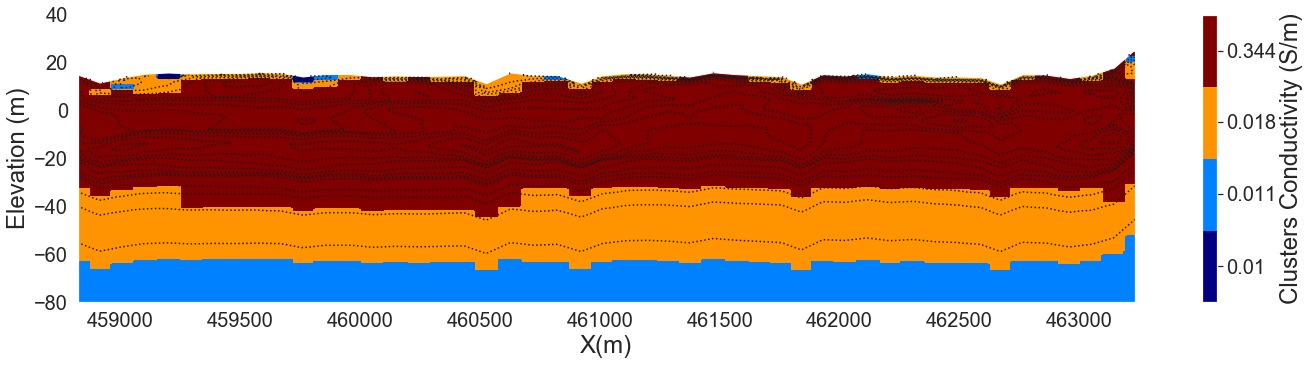

In [13]:
# Plot the classified cross-section with 4 units with the GMM generated in the BIC
n = clfl2_4units.n_components
fig,ax = plt.subplots(1,1,figsize=(20,5))
order_clusters_GM_mean(clfl2_4units0)
n = clfl2_4units0.n_components
moptm = mopt.reshape((hz.size, n_sounding), order='F')
sigma = mapping * mopt
Sigma = sigma.reshape((hz.size, n_sounding), order='F')
sigma_xz = Utils.mkvc(Sigma[:,ind_line])
classificationl2 = clfl2_4units0.predict(mopt[:,np.newaxis])
classificationl2 = classificationl2.reshape((hz.size, n_sounding), order='F')
classificationl2xz = Utils.mkvc(classificationl2[:,ind_line])
moptxz = Utils.mkvc(moptm[:,ind_line])

mm = plot2Ddata(xz, sigma_xz, scale='log',ax=ax,
                      level=True, 
                      ncontour=16,
                      levelOpts={'colors':'k','linewidths':1.5, 'linestyles':'dotted'},
                      clim=10.**(np.r_[-3,1]),
                      mask=mask,
                nx=nx,
                        ny=ny,
                      contourOpts={'cmap':'viridis'},
                      dataloc=False)

mm =plot2Ddata_categorical(xz,
                      classificationl2xz,ax=ax, scale='linear',
                      dataloc=False,
                      clim=[0.99,2.99],
                     ncontour=1,
                           nx=nx,
                        ny=ny,
                     contourOpts={'cmap':'jet',
                                  },)

plt.fill_between(topo[ind_line, 0], topo[ind_line, 2], topo[ind_line, 1]*0. + zmax, color='w')
plt.gca().set_aspect(10)
plt.gca().set_ylim([-80,40])
cb = plt.colorbar(mm[0], format='%.1e')
cb.set_ticks(np.r_[0.5+np.linspace(0,n-1,n),n-1.005])
cb.set_ticklabels([str(round(i[0],3)) for i in (10.**(np.log10(np.exp(clfl2_4units0.means_))))])

cb.set_label('Clusters Conductivity (S/m)',fontsize=24)
cb.ax.tick_params(labelsize=20) 
plt.gca().tick_params(labelsize=20)
ax.set_xlabel('X(m)',fontsize=24)
ax.set_ylabel('Elevation (m)',fontsize=24)
plt.tight_layout()

#fig.savefig("Booky_L2_classification4n1_HighRes.png", dpi=600, bbox_inches='tight', pad_inches=0.1)
#fig.savefig("Booky_L2_classification4n1_LowRes.png", dpi=72, bbox_inches='tight', pad_inches=0.1)

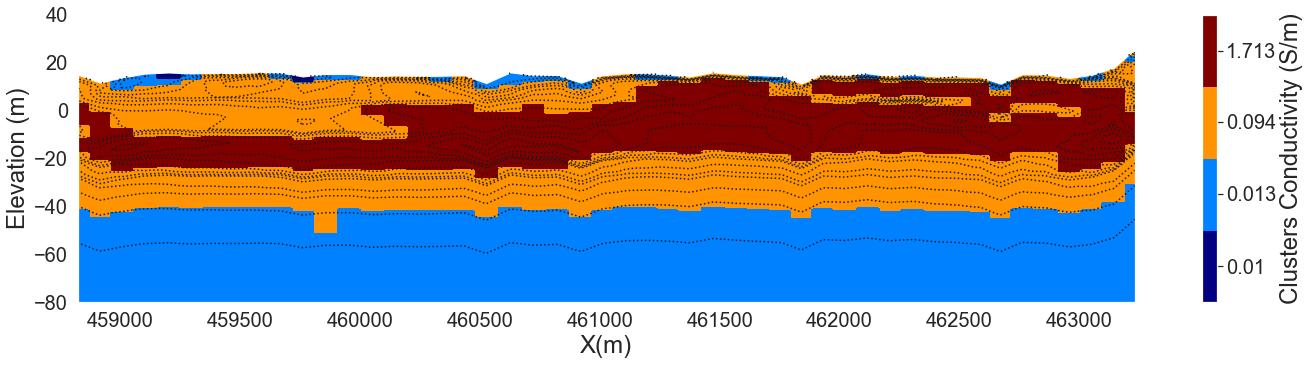

In [14]:
# Plot the classified cross-section with 4 units with the GMM clfl2_4units
n = clfl2_4units.n_components
fig,ax = plt.subplots(1,1,figsize=(20,5))
moptm = mopt.reshape((hz.size, n_sounding), order='F')
sigma = mapping * mopt
Sigma = sigma.reshape((hz.size, n_sounding), order='F')
sigma_xz = Utils.mkvc(Sigma[:,ind_line])
classificationl2 = clfl2_4units.predict(mopt[:,np.newaxis])
classificationl2 = classificationl2.reshape((hz.size, n_sounding), order='F')
classificationl2xz = Utils.mkvc(classificationl2[:,ind_line])
moptxz = Utils.mkvc(moptm[:,ind_line])

mm = plot2Ddata(xz, sigma_xz, scale='log',ax=ax,
                      level=True, 
                      ncontour=16,
                      levelOpts={'colors':'k','linewidths':1.5, 'linestyles':'dotted'},
                      clim=10.**(np.r_[-3,1]),
                      mask=mask,
                nx=nx,
                        ny=ny,
                      contourOpts={'cmap':'viridis'},
                      dataloc=False)

mm =plot2Ddata_categorical(xz,
                      classificationl2xz,ax=ax, scale='linear',
                      dataloc=False,
                      clim=[0.99,2.99],
                     ncontour=1,
                           nx=nx,
                        ny=ny,
                     contourOpts={'cmap':'jet',
                                  },)

plt.fill_between(topo[ind_line, 0], topo[ind_line, 2], topo[ind_line, 1]*0. + zmax, color='w')
plt.gca().set_aspect(10)
plt.gca().set_ylim([-80,40])
cb = plt.colorbar(mm[0], format='%.1e')
cb.set_ticks(np.r_[0.5+np.linspace(0,n-1,n),n-1.005])
cb.set_ticklabels([str(round(i[0],3)) for i in (10.**(np.log10(np.exp(clfl2_4units.means_))))])

cb.set_label('Clusters Conductivity (S/m)',fontsize=24)
cb.ax.tick_params(labelsize=20) 
plt.gca().tick_params(labelsize=20)
ax.set_xlabel('X(m)',fontsize=24)
ax.set_ylabel('Elevation (m)',fontsize=24)
plt.tight_layout()

#fig.savefig("Booky_L2_classification4n2_HighRes.png", dpi=600, bbox_inches='tight', pad_inches=0.1)
#fig.savefig("Booky_L2_classification4n2_LowRes.png", dpi=72, bbox_inches='tight', pad_inches=0.1)

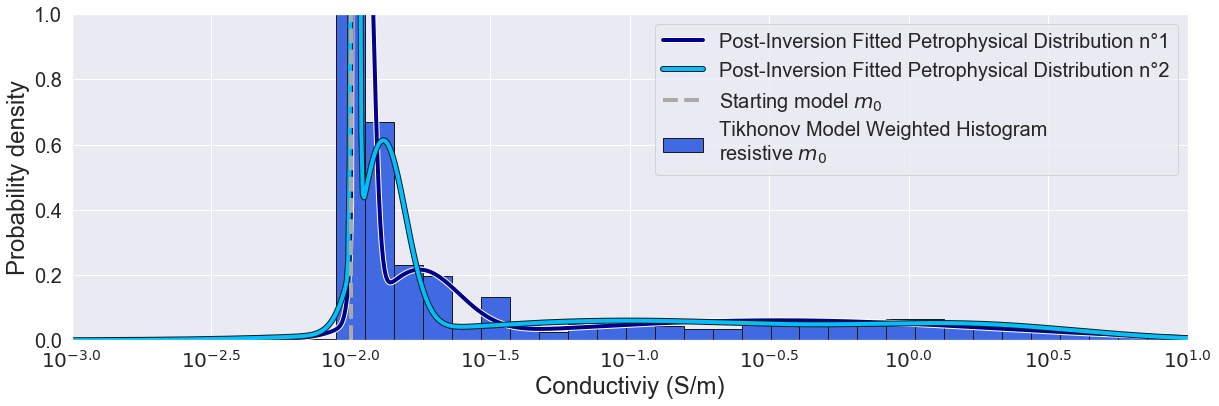

In [15]:
# Plot the Tikhonov recovered model and the two GMM classifiers
m0 = np.ones_like(m0)*np.log(1e-2)
testXplot = np.linspace(-8.,4,1000)[:,np.newaxis]
fig = plt.figure(figsize=(20,6))
hist, edges = np.histogram(mopt,bins=75, density=True,weights=mesh_reg.vol)
plt.gca().bar(np.log10(np.exp(edges[:-1])), hist, width=np.diff(np.log10(np.exp(edges))), ec="k", align="edge",
              label='Tikhonov Model Weighted Histogram\nresistive $m_0$',color='royalblue')
plt.plot(np.log10(np.exp(testXplot)),np.exp(clfl2_4units0.score_samples(testXplot)),
         linewidth=4,c='darkblue',
         label='Post-Inversion Fitted Petrophysical Distribution n°1',
    path_effects=[pe.Stroke(linewidth=6, foreground='w'), pe.Normal()])

plt.plot(np.log10(np.exp(testXplot)),np.exp(clfl2_4units.score_samples(testXplot)),
         linewidth=4,c='deepskyblue',
         label='Post-Inversion Fitted Petrophysical Distribution n°2',
    path_effects=[pe.Stroke(linewidth=6, foreground='k'), pe.Normal()])
plt.gca().set_ylim([0.,1.])
plt.gca().set_xlim([-3.,1.])
plt.gca().set_xlabel('Conductiviy (S/m)',fontsize=24)
plt.gca().set_ylabel('Probability density',fontsize=24)

plt.gca().tick_params(labelsize=20)
plt.gca().set_xticks([-3,-2.5,-2,-1.5,-1,-0.5,0,0.5,1])
plt.gca().xaxis.set_major_formatter(plt.FormatStrFormatter('$10^{%.1f}$'))
plt.gca().grid(b=True, which='minor', color='r', linestyle='--')
plt.gca().plot(np.log10(np.exp(np.unique(m0)))*np.ones(2),[0,5],linestyle='dashed',
               color='darkgray',linewidth=4,
              label='Starting model $m_0$')
plt.gca().legend(fontsize=20)
plt.show()

#fig.savefig("Booky_L2_Hist_HighRes.png", dpi=600, bbox_inches='tight', pad_inches=0.1)
#fig.savefig("Booky_L2_Hist_LowRes.png", dpi=72, bbox_inches='tight', pad_inches=0.1)

# Tikhonov, starting from a conductive background

In [16]:
# Start from a conductive background
m0 = np.ones(mesh_reg.nC) * np.log(1.)
dmisfit = DataMisfit.l2_DataMisfit(survey,std=std,eps=floor)
dmisfit.W = 1./uncert

# Create the laterally constrained regularizer
regmap = Maps.IdentityMap(mesh_reg)
reg = LateralConstraint(
    mesh_reg, mapping=Maps.IdentityMap(nP=mesh_reg.nC),
    alpha_s=1.,
    alpha_x = 10.,
    alpha_y = 1.,        
)
tri = reg.get_grad_horizontal(xy, hz)

# Optimization
opt = Optimization.ProjectedGNCG(maxIter=20,
                                 maxIterLS=20, maxIterCG=20, tolCG=1e-1)
invProb = InvProblem.BaseInvProblem(dmisfit, reg, opt)
prob.counter = opt.counter = Utils.Counter()
opt.LSshorten = 0.5
opt.remember('xc')
invProb.beta=1e-2

# Inversion directives
beta = Directives.BetaSchedule(coolingFactor=5, coolingRate=3)
betaest = Directives.BetaEstimate_ByEig(beta0_ratio=1.)
target = Directives.TargetMisfit()
inv = Inversion.BaseInversion(invProb, directiveList=[
                                                      beta,
                                                      target,])

# Run
mopt_cond = inv.run(m0)

SimPEG.InvProblem will set Regularization.mref to m0.

                SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                ***Done using same Solver and solverOpts as the problem***
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  1.00e-02  9.36e+04  0.00e+00  9.36e+04    3.87e+03      0              
   1  1.00e-02  4.90e+04  3.52e+04  4.93e+04    2.31e+03      0              
   2  1.00e-02  2.91e+04  9.70e+04  3.00e+04    1.72e+03      0   Skip BFGS  
   3  2.00e-03  1.84e+04  1.49e+05  1.87e+04    3.96e+02      0              
   4  2.00e-03  1.12e+04  2.06e+05  1.16e+04    1.40e+03      1              
   5  2.00e-03  6.17e+03  2.24e+05  6.62e+03    4.43e+02      0              
------------------------- STOP! ----------

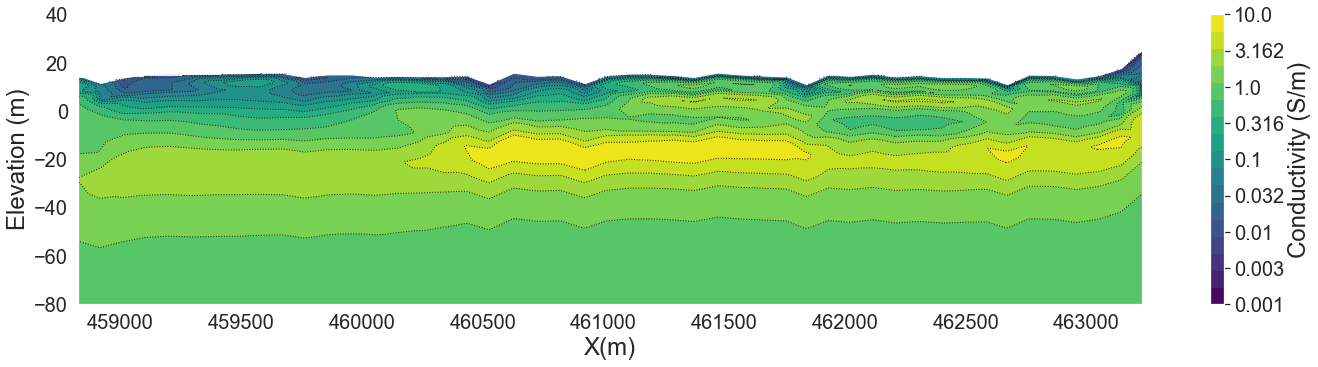

In [17]:
# Plot the cross-section of the Tikhonov recovered model, initial from a conductive model
fig,ax = plt.subplots(1,1,figsize=(20,5))
moptm = mopt_cond.reshape((hz.size, n_sounding), order='F')
mopt_xz = Utils.mkvc(moptm[:,ind_line])
sigma = mapping * mopt_cond
Sigma = sigma.reshape((hz.size, n_sounding), order='F')
sigma_xz = Utils.mkvc(Sigma[:,ind_line])

mm = plot2Ddata(xz, sigma_xz, scale='log',ax=ax,
                      level=True, 
                      ncontour=16,
                      levelOpts={'colors':'k','linewidths':1, 'linestyles':'dotted'},
                      clim=10.**(np.r_[-3,1]),
                      mask=mask,
                nx=nx,
                        ny=ny,
                      contourOpts={'cmap':'viridis'},
                      dataloc=False)
plt.fill_between(topo[ind_line, 0], topo[ind_line, 2], topo[ind_line, 1]*0. + zmax, color='w')
plt.gca().set_aspect(10)
plt.gca().set_ylim([-80,40])
cb = plt.colorbar(mm[0], format='%.1e')
cb.set_ticks(np.linspace(-3,1.,9))
cb.set_ticklabels([str(round(i,3)) for i in (10.**np.linspace(-3,1,9))])

cb.set_label('Conductivity (S/m)',fontsize=24)
cb.ax.tick_params(labelsize=20) 
plt.gca().tick_params(labelsize=20)
ax.set_xlabel('X(m)',fontsize=24)
ax.set_ylabel('Elevation (m)',fontsize=24)
plt.tight_layout()

#fig.savefig("Booky_L2_cond_HighRes.png", dpi=600, bbox_inches='tight', pad_inches=0.1)
#fig.savefig("Booky_L2_cond_LowRes.png", dpi=72, bbox_inches='tight', pad_inches=0.1)#

In [18]:
#BIC criteria: uncomment to run
#import copy
#biclist_tik_cond = []
#clflist_tik_cond = []
#X = mopt_cond[:,np.newaxis]
#for i in range(1,7):
#    clfbic_tik_cond = Utils.WeightedGaussianMixture(n_components=i,
#                      covariance_type='full',
#                    mesh = mesh_reg,
#                      reg_covar=1e-6,
#                      n_init=100,
#                      max_iter=100,
#                      tol=1e-5)
#    clfbic_tik_cond.fit(X)
#    biclist_tik_cond.append(clfbic_tik_cond.bic(X))
#    clflist_tik_cond.append(copy.deepcopy(clfbic_tik_cond))
#    print(i)

In [19]:
# BIC measurement for GMM fitting
#fig, ax = plt.subplots(1,1,figsize=(10,5))
#ax.plot(range(1,7),biclist_tik_cond,'ko-')
#ax.set_xlabel('# of clusters',fontsize=22)
#ax.set_ylabel('BIC measure',fontsize=22)
#ax.tick_params(labelsize=20)
#ax.scatter([4],biclist_tik_cond[3],s=500,c='r',label='Chosen number\nof clusters')
#ax.legend(fontsize=22)
#ax.set_title('BIC measurement to fit a GMM\non the Tikhonov from conductive initial model', fontsize=20)
#plt.show()
#fig.savefig("Booky_L2_cond_BIC_HighRes.png", dpi=600, bbox_inches='tight', pad_inches=0.1)
#fig.savefig("Booky_L2_cond_BIC_LowRes.png", dpi=72, bbox_inches='tight', pad_inches=0.1)

In [20]:
# Create a 4 units GMM classfier
n = 4 #number of units
X = mopt_cond[:,np.newaxis]
clfl2_cond0 = Utils.WeightedGaussianMixture(
    n_components=n,
    covariance_type='full',
    mesh = mesh_reg,
    reg_covar=1e-6,
    n_init=100,
    max_iter=100,
    tol=1e-5
)
clfl2_cond0.fit(mopt_cond.reshape(-1,1))
Utils.order_clusters_GM_weight(clfl2_cond0)
order_clusters_GM_mean(clfl2_cond0)

In [21]:
# Create a second 4 units GMM classfier
n = 4 #number of units
X = mopt_cond[:,np.newaxis]
clfl2_cond = Utils.WeightedGaussianMixture(
    n_components=n,
    covariance_type='full',
    mesh=mesh_reg,
    reg_covar=1e-6,
    n_init=100,
    max_iter=100,
    tol=1e-1
)
clfl2_cond.fit(mopt_cond.reshape(-1,1))
Utils.order_clusters_GM_weight(clfl2_cond)
order_clusters_GM_mean(clfl2_cond)

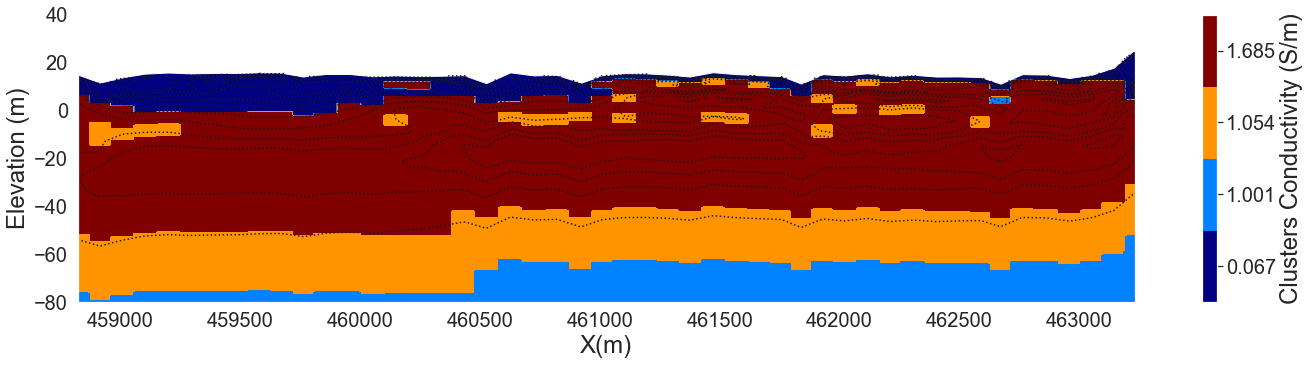

In [22]:
# Plot the classified cross-section with the GMM from the BIC measurement
fig,ax = plt.subplots(1,1,figsize=(20,5))
order_clusters_GM_mean(clfl2_cond0)
n = clfl2_cond0.n_components
moptm = mopt_cond.reshape((hz.size, n_sounding), order='F')
sigma_cond = mapping * mopt_cond
Sigma_cond = sigma_cond.reshape((hz.size, n_sounding), order='F')
sigma_xz_cond = Utils.mkvc(Sigma_cond[:,ind_line])
classificationl2_cond = clfl2_cond0.predict(mopt_cond[:,np.newaxis])
classificationl2_cond = classificationl2_cond.reshape((hz.size, n_sounding), order='F')
classificationl2_condxz = Utils.mkvc(classificationl2_cond[:,ind_line])
moptxz = Utils.mkvc(moptm[:,ind_line])

mm = plot2Ddata(xz, sigma_xz_cond, scale='log',ax=ax,
                      level=True, 
                      ncontour=16,
                      levelOpts={'colors':'k','linewidths':1.5, 'linestyles':'dotted'},
                      clim=10.**(np.r_[-3,1]),
                      mask=mask,
                nx=nx,
                        ny=ny,
                      contourOpts={'cmap':'viridis'},
                      dataloc=False)

mm =plot2Ddata_categorical(xz,
                      classificationl2_condxz,ax=ax, scale='linear',
                      dataloc=False,
                      clim=[0.999,2.999],
                     ncontour=1,
                           nx=nx,
                        ny=ny,
                     contourOpts={'cmap':'jet',
                                  },)

plt.fill_between(topo[ind_line, 0], topo[ind_line, 2], topo[ind_line, 1]*0. + zmax, color='w')
plt.gca().set_aspect(10)
plt.gca().set_ylim([-80,40])
cb = plt.colorbar(mm[0], format='%.1e')
cb.set_ticks([0.5,1.5,2.5,2.9995])
cb.set_ticklabels([str(round(i[0],3)) for i in (10.**(np.log10(np.exp(clfl2_cond0.means_))))])

cb.set_label('Clusters Conductivity (S/m)',fontsize=24)
cb.ax.tick_params(labelsize=20) 
plt.gca().tick_params(labelsize=20)
ax.set_xlabel('X(m)',fontsize=24)
ax.set_ylabel('Elevation (m)',fontsize=24)
plt.tight_layout()

#fig.savefig("Booky_L2_cond_classification4n1_HighRes.png", dpi=600, bbox_inches='tight', pad_inches=0.1)
#fig.savefig("Booky_L2_cond_classification4n1_LowRes.png", dpi=72, bbox_inches='tight', pad_inches=0.1)

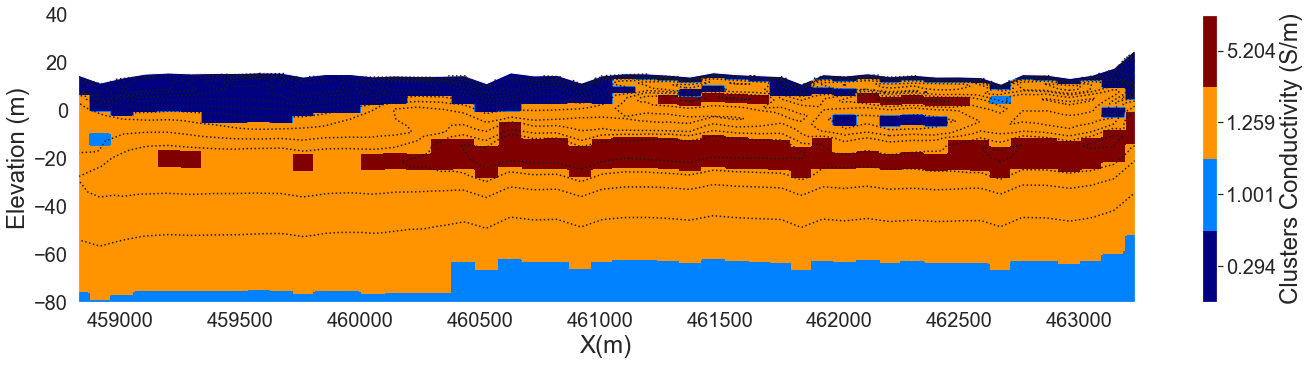

In [23]:
# Plot the classified cross-section with the secondly trained GMM
fig,ax = plt.subplots(1,1,figsize=(20,5))
n = clfl2_cond.n_components
moptm = mopt_cond.reshape((hz.size, n_sounding), order='F')
sigma_cond = mapping * mopt_cond
Sigma_cond = sigma_cond.reshape((hz.size, n_sounding), order='F')
sigma_xz_cond = Utils.mkvc(Sigma_cond[:,ind_line])
classificationl2_cond = clfl2_cond.predict(mopt_cond[:,np.newaxis])
classificationl2_cond = classificationl2_cond.reshape((hz.size, n_sounding), order='F')
classificationl2_condxz = Utils.mkvc(classificationl2_cond[:,ind_line])
moptxz = Utils.mkvc(moptm[:,ind_line])

mm = plot2Ddata(xz, sigma_xz_cond, scale='log',ax=ax,
                      level=True, 
                      ncontour=16,
                      levelOpts={'colors':'k','linewidths':1.5, 'linestyles':'dotted'},
                      clim=10.**(np.r_[-3,1]),
                      mask=mask,
                nx=nx,
                        ny=ny,
                      contourOpts={'cmap':'viridis'},
                      dataloc=False)

mm =plot2Ddata_categorical(xz,
                      classificationl2_condxz,ax=ax, scale='linear',
                      dataloc=False,
                      clim=[0.999,2.999],
                     ncontour=1,
                           nx=nx,
                        ny=ny,
                     contourOpts={'cmap':'jet',
                                  },)

plt.fill_between(topo[ind_line, 0], topo[ind_line, 2], topo[ind_line, 1]*0. + zmax, color='w')
plt.gca().set_aspect(10)
plt.gca().set_ylim([-80,40])
cb = plt.colorbar(mm[0], format='%.1e')
cb.set_ticks([0.5,1.5,2.5,2.9995])
cb.set_ticklabels([str(round(i[0],3)) for i in (10.**(np.log10(np.exp(clfl2_cond.means_))))])

cb.set_label('Clusters Conductivity (S/m)',fontsize=24)
cb.ax.tick_params(labelsize=20) 
plt.gca().tick_params(labelsize=20)
ax.set_xlabel('X(m)',fontsize=24)
ax.set_ylabel('Elevation (m)',fontsize=24)
plt.tight_layout()

#fig.savefig("Booky_L2_cond_classification4n2_HighRes.png", dpi=600, bbox_inches='tight', pad_inches=0.1)
#fig.savefig("Booky_L2_cond_classification4n2_LowRes.png", dpi=72, bbox_inches='tight', pad_inches=0.1)

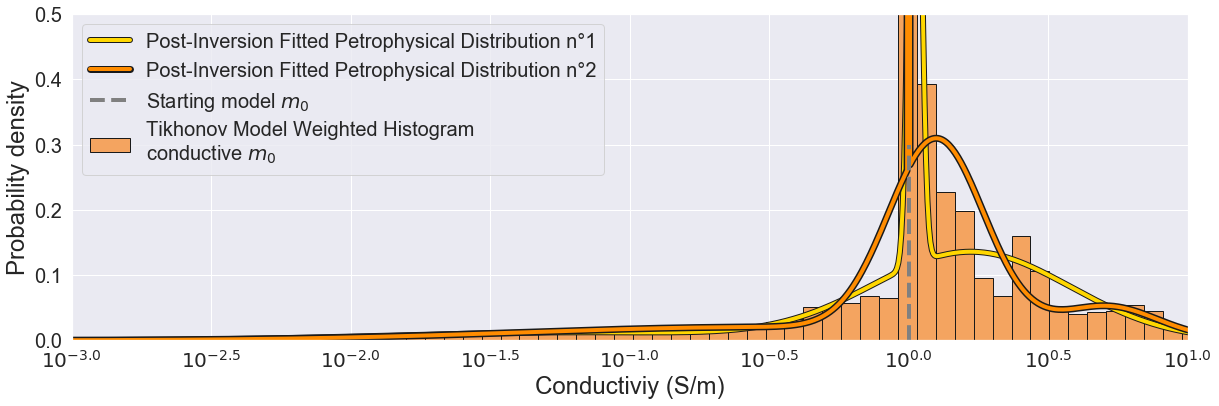

In [24]:
# Plot the Tikhonov recovered model and the two GMM classifiers
m0 = np.ones_like(m0)*np.log(1)
fig = plt.figure(figsize=(20,6))
hist, edges = np.histogram(mopt_cond,bins=75, density=True,weights=mesh_reg.vol)
plt.gca().bar(np.log10(np.exp(edges[:-1])), hist, width=np.diff(np.log10(np.exp(edges))), ec="k", align="edge",
              label='Tikhonov Model Weighted Histogram\nconductive $m_0$',color='sandybrown')
plt.plot(np.log10(np.exp(testXplot)),np.exp(clfl2_cond0.score_samples(testXplot)),
         linewidth=4,c='gold',
         label='Post-Inversion Fitted Petrophysical Distribution n°1',
        path_effects=[pe.Stroke(linewidth=6, foreground='k'), pe.Normal()])
plt.plot(np.log10(np.exp(testXplot)),np.exp(clfl2_cond.score_samples(testXplot)),
         linewidth=4,c='darkorange',
         label='Post-Inversion Fitted Petrophysical Distribution n°2',
    path_effects=[pe.Stroke(linewidth=7, foreground='k'), pe.Normal()])

plt.gca().set_ylim([0.,.5])
plt.gca().set_xlim([-3.,1.])
plt.gca().set_xlabel('Conductiviy (S/m)',fontsize=24)
plt.gca().set_ylabel('Probability density',fontsize=24)
plt.gca().tick_params(labelsize=20)
plt.gca().set_xticks([-3,-2.5,-2,-1.5,-1,-0.5,0,0.5,1])
plt.gca().xaxis.set_major_formatter(plt.FormatStrFormatter('$10^{%.1f}$'))
plt.gca().grid(b=True, which='minor', color='r', linestyle='--')
plt.gca().plot(np.log10(np.exp(np.unique(m0)))*np.ones(2),[0,0.3],linestyle='dashed',
               color='gray',linewidth=4,
              label='Starting model $m_0$')
plt.gca().legend(fontsize=20)
plt.show()

#fig.savefig("Booky_L2_cond_Hist_HighRes.png", dpi=600, bbox_inches='tight', pad_inches=0.1)
#fig.savefig("Booky_L2_cond_Hist_LowRes.png", dpi=72, bbox_inches='tight', pad_inches=0.1)

# PGI

In [25]:
# GMM prior design
n = 3 #number of units
X = (m0+np.random.rand(len(m0)))[:,np.newaxis]
clfref = Utils.WeightedGaussianMixture(
                      n_components=n,
                      covariance_type='full',
                    mesh=mesh_reg,
                      reg_covar=1e-6,
                      n_init=10,
                      max_iter=100,
                      tol=1e-3)
clfref.fit(X)
Utils.order_clusters_GM_weight(clfref)
clfref.means_ =np.log(1./np.r_[100,10,1]).reshape(3,1)
cov_init = 1e-1*np.c_[[[[1]],[[1]],[[1]]]]
clfref.covariances_ = cov_init
clfref.precisions_cholesky_ = Utils._compute_precision_cholesky(
    clfref.covariances_, clfref.covariance_type
)
clfref.weights_ = 1./3.*np.ones(3)
Utils.computePrecision(clfref)
Utils.order_clusters_GM_weight(clfref)

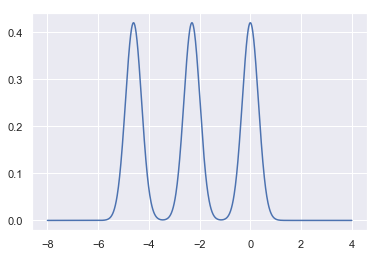

In [26]:
# Plot the prior, the means are meaningless
testXplot = np.linspace(-8.,4,1000)[:,np.newaxis]
plt.plot(testXplot,np.exp(clfref.score_samples(testXplot)))

# PGI with initial resistive background

In [40]:
# Initial model
m0 = np.ones(mesh_reg.nC) * np.log(1./100.)
dmisfit = DataMisfit.l2_DataMisfit(survey,std=std,eps=floor)
dmisfit.W = 1./uncert

# Optimization
opt = Optimization.ProjectedGNCG(maxIter=20, #lower=-10, upper=10,
                                 maxIterLS=20, maxIterCG=20, tolCG=1e-1)
prob.counter = opt.counter = Utils.Counter()
opt.LSshorten = 0.5
opt.remember('xc')

# Set the regularization: Lateral constraint + GMM guided
regmap = Maps.IdentityMap(mesh_reg)
regL = LateralConstraint(
    mesh_reg, mapping=Maps.IdentityMap(nP=mesh_reg.nC),
    alpha_s= 0.,
    alpha_x = 10.,
    alpha_y = 1.,        
)
tri = regL.get_grad_horizontal(xy, hz)

# Petro Regularization
regP = Regularization.PetroRegularization(
    GMmref=clfref,
    GMmodel=clfref,
    mesh=mesh_reg,
    wiresmap=None,
    maplist=[Maps.IdentityMap(nP=mesh_reg.nC)],
    mref=m0,
    alpha_s=0.1, alpha_x=0.0, alpha_y=0.0, alpha_z=0.0,
    alpha_xx=0., alpha_yy=0., alpha_zz=0.,
    cell_weights=np.ones(mesh_reg.nC)
)

reg = regP + regL

# Set Inverse problem
invProb = InvProblem.BaseInvProblem(dmisfit, reg, opt)

#Beta cooling schedule
betaIt = Directives.PetroBetaReWeighting(
    verbose=True, rateCooling=5., rateWarming=1.,
    tolerance=0.1, UpdateRate=1,
    ratio_in_cooling=False,
    progress=0.2,
    update_prior_confidence=False,
    progress_gamma_cooling=0.01,
    ratio_in_gamma_cooling=False,
    alphadir_rateCooling=1.,
    kappa_rateCooling=1.,
    nu_rateCooling=1.,
)

#Target misfit for petroguided
targets = Directives.PetroTargetMisfit(
    verbose=True,
    chiSmall=1.,
    chifact=1.

)
#Add mref in smooth when stable
MrefInSmooth = Directives.AddMrefInSmooth(
    wait_till_stable=True,
    verbose=True,
    tolerance=0.0
)

# Train a new petro model at each iteration
petrodir = Directives.GaussianMixtureUpdateModel(
    kappa = 0.,
    update_covariances=True,
    nu = 1.,
    alphadir = 0.,
    keep_ref_fixed_in_Smooth=True,
    verbose=False
)

# Same beta as for Tikhonov
invProb.beta = 1e-02

# Inversion directives
inv = Inversion.BaseInversion(invProb, directiveList=[
        petrodir, targets,
        MrefInSmooth,
        betaIt,
])

# Run
mopt_petro = inv.run(m0)
clfrecoverednogeo = copy.deepcopy(invProb.reg.objfcts[0].GMmodel)

SimPEG.InvProblem will set Regularization.mref to m0.

                SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                ***Done using same Solver and solverOpts as the problem***
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  1.00e-02  1.91e+05  0.00e+00  1.91e+05    1.47e+03      0              
DM:  [43824.3709578] [False] ; CL:  19579.806523602194 False ; DP:  True ; All: False
mref changes in  13787  places
progress [43824.3709578] >< [152678.07319957]
   1  1.00e-02  4.38e+04  8.97e+04  4.47e+04    5.18e+02      0              
DM:  [40309.05721212] [False] ; CL:  18597.518169692386 False ; DP:  True ; All: False
mref changes in  4408  places
progress [40309.05721212] >< [35059.49676624]
update beta for countering p

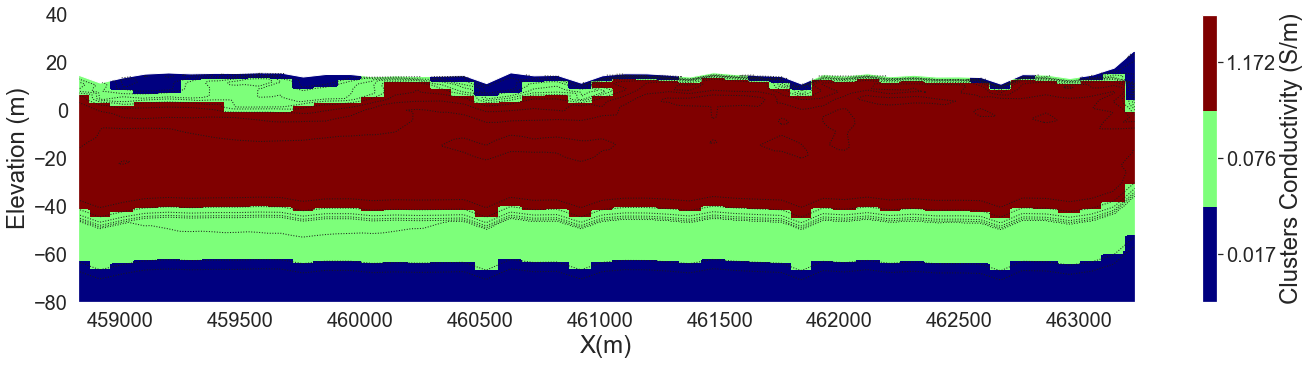

In [41]:
# Plot the cross-section of the quasi-geological model
fig,ax = plt.subplots(1,1,figsize=(20,5))
order_clusters_GM_mean(clfrecoverednogeo)
moptm = mopt_petro.reshape((hz.size, n_sounding), order='F')
mopt_petro_xz = Utils.mkvc(moptm[:,ind_line])
sigma_petro = mapping * mopt_petro
Sigma_petro = sigma_petro.reshape((hz.size, n_sounding), order='F')
sigma_xz_petro = Utils.mkvc(Sigma_petro[:,ind_line])

mm = plot2Ddata(xz, sigma_xz_petro, scale='log',ax=ax,
                      level=True, 
                      ncontour=16,
                      levelOpts={'colors':'k','linewidths':1, 'linestyles':'dotted'},
                      clim=10.**(np.r_[-3,1]),
                      mask=mask,
                        nx=nx,
                        ny=ny,
                      contourOpts={'cmap':'viridis'},
                      dataloc=False
)
mm =plot2Ddata_categorical(xz,
                      clfrecoverednogeo.predict(np.log(sigma_xz_petro)[:,np.newaxis]),
                           ax=ax, scale='linear',
                           nx=nx,
                        ny=ny,
                      dataloc=False,
                      clim=[0.9999,1.9999],
                     ncontour=0,
                     contourOpts={'cmap':'jet',},
)
plt.fill_between(topo[ind_line, 0], topo[ind_line, 2], topo[ind_line, 1]*0. + zmax, color='w')
plt.gca().set_aspect(10)
plt.gca().set_ylim([-80,40])
cb = plt.colorbar(mm[0], format='%.1e')
cb.set_ticks([0.5,1.5,1.99995])
cb.set_ticklabels([str(round(i[0],3)) for i in (10.**(np.log10(np.exp(clfrecoverednogeo.means_))))])

cb.set_label('Clusters Conductivity (S/m)',fontsize=24)
cb.ax.tick_params(labelsize=20) 
plt.gca().tick_params(labelsize=20)
ax.set_xlabel('X(m)',fontsize=24)
ax.set_ylabel('Elevation (m)',fontsize=24)
plt.tight_layout()

#fig.savefig("Booky_petro3units_classification_HighRes.png", dpi=600, bbox_inches='tight', pad_inches=0.1)
#fig.savefig("Booky_petro3units_classification_LowRes.png", dpi=72, bbox_inches='tight', pad_inches=0.1)

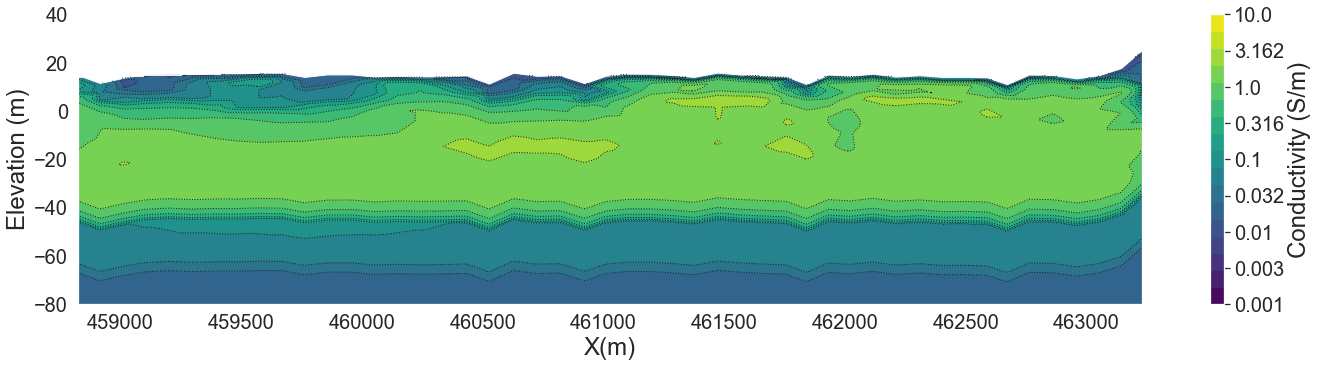

In [42]:
# Plot the PGI recovered model, initial resistive background
fig,ax = plt.subplots(1,1,figsize=(20,5))
order_clusters_GM_mean(clfrecoverednogeo)
moptm = mopt_petro.reshape((hz.size, n_sounding), order='F')
mopt_petro_xz = Utils.mkvc(moptm[:,ind_line])
sigma_petro = mapping * mopt_petro
Sigma_petro = sigma_petro.reshape((hz.size, n_sounding), order='F')
sigma_xz_petro = Utils.mkvc(Sigma_petro[:,ind_line])

mm = plot2Ddata(
    xz, sigma_xz_petro, scale='log',ax=ax,
    level=True, 
    ncontour=16,
    levelOpts={'colors':'k','linewidths':1, 'linestyles':'dotted'},
    clim=10.**(np.r_[-3,1]),
    mask=mask,
    nx=nx,
    ny=ny,
    contourOpts={'cmap':'viridis'},
    dataloc=False
)

plt.fill_between(topo[ind_line, 0], topo[ind_line, 2], topo[ind_line, 1]*0. + zmax, color='w')
plt.gca().set_aspect(10)
plt.gca().set_ylim([-80,40])
cb = plt.colorbar(mm[0], format='%.1e')
cb.set_ticks(np.linspace(-3,1.,9))
cb.set_ticklabels([str(round(i,3)) for i in (10.**np.linspace(-3,1,9))])

cb.set_label('Conductivity (S/m)',fontsize=24)
cb.ax.tick_params(labelsize=20) 
plt.gca().tick_params(labelsize=20)
ax.set_xlabel('X(m)',fontsize=24)
ax.set_ylabel('Elevation (m)',fontsize=24)
plt.tight_layout()

#fig.savefig("Booky_petro3units_2_HighRes.png", dpi=600, bbox_inches='tight', pad_inches=0.1)
#fig.savefig("Booky_petro3units_2_LowRes.png", dpi=72, bbox_inches='tight', pad_inches=0.1)

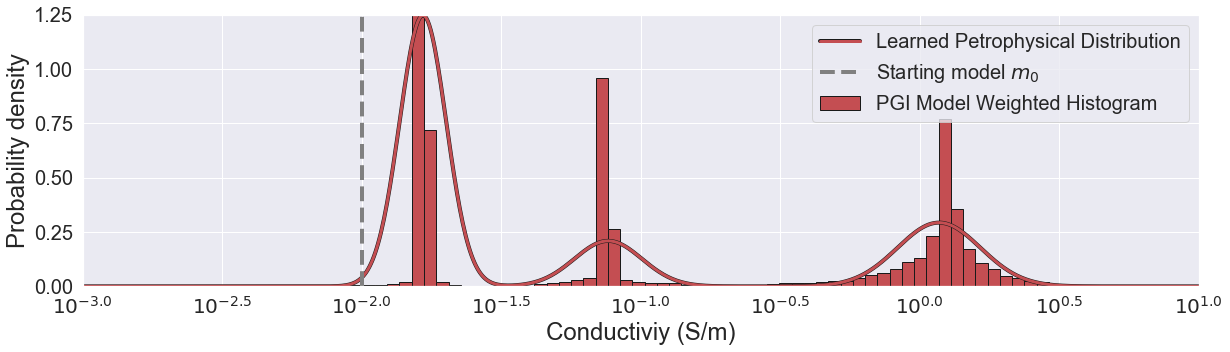

In [44]:
# Plot the learned petrophysical distribution and PGI model histogram, initial resistive model
m0 = np.ones_like(m0)*np.log(1e-2)
fig = plt.figure(figsize=(20,5))
hist, edges = np.histogram(mopt_petro,bins=75, density=True,weights=mesh_reg.vol)
plt.gca().bar(np.log10(np.exp(edges[:-1])), hist, width=np.diff(np.log10(np.exp(edges))), ec="k", align="edge",
              label='PGI Model Weighted Histogram',color='r')
plt.plot(np.log10(np.exp(testXplot)),np.exp(clfrecoverednogeo.score_samples(testXplot)),
         linewidth=3,c='r',
         label='Learned Petrophysical Distribution',
    path_effects=[pe.Stroke(linewidth=4, foreground='k'), pe.Normal()])
plt.gca().set_ylim([0.,1.25])
plt.gca().set_xlim([-3.,1.])
plt.gca().set_xlabel('Conductiviy (S/m)',fontsize=24)
plt.gca().set_ylabel('Probability density',fontsize=24)

plt.gca().tick_params(labelsize=20)
plt.gca().set_xticks([-3,-2.5,-2,-1.5,-1,-0.5,0,0.5,1])
plt.gca().xaxis.set_major_formatter(plt.FormatStrFormatter('$10^{%.1f}$'))
plt.gca().grid(b=True, which='minor', color='r', linestyle='--')
plt.gca().plot(np.log10(np.exp(np.unique(m0)))*np.ones(2),[0,5],linestyle='dashed',
               color='gray',linewidth=4,
              label='Starting model $m_0$')
plt.gca().legend(fontsize=20)
plt.show()

#fig.savefig("Booky_petro3units_Hist_HighRes.png", dpi=600, bbox_inches='tight', pad_inches=0.1)
#fig.savefig("Booky_petro3units_Hist_LowRes.png", dpi=72, bbox_inches='tight', pad_inches=0.1)

# PGI, conductive initial background

In [36]:
# Conductive initial background
m0 = np.ones(mesh_reg.nC) * np.log(1.)
dmisfit = DataMisfit.l2_DataMisfit(survey,std=std,eps=floor)
dmisfit.W = 1./uncert

# Optimization
opt = Optimization.ProjectedGNCG(
    maxIter=20,maxIterLS=20, maxIterCG=20, tolCG=1e-1
)
prob.counter = opt.counter = Utils.Counter()
opt.LSshorten = 0.5
opt.remember('xc')

# Set the regularization: Lateral constraint + GMM guided
regmap = Maps.IdentityMap(mesh_reg)
# Lateral-constraints
regL = LateralConstraint(
    mesh_reg, mapping=Maps.IdentityMap(nP=mesh_reg.nC),
    alpha_s= 0.,
    alpha_x = 10.,
    alpha_y = 1.,        
)
tri = regL.get_grad_horizontal(xy, hz)
# Petro Regularization
regP = Regularization.PetroRegularization(
    GMmref=clfref,
    GMmodel=clfref,
    mesh=mesh_reg,
    wiresmap=None,
    maplist=[Maps.IdentityMap(nP=mesh_reg.nC)],
    mref=m0,
    alpha_s=0.1, alpha_x=0.0, alpha_y=0.0, alpha_z=0.0,
    alpha_xx=0., alpha_yy=0., alpha_zz=0.,
    cell_weights=np.ones(mesh_reg.nC)
)
reg = regP + regL


# Create inverse problem
invProb = InvProblem.BaseInvProblem(dmisfit, reg, opt)

# Directives
#Beta cooling schedule
betaIt = Directives.PetroBetaReWeighting(
    verbose=True, rateCooling=5., rateWarming=1.,
    tolerance=0.1, UpdateRate=1,
    ratio_in_cooling=False,
    progress=0.2,
    update_prior_confidence=False,
    progress_gamma_cooling=0.01,
    ratio_in_gamma_cooling=False,
    alphadir_rateCooling=1.,
    kappa_rateCooling=1.,
    nu_rateCooling=1.,
)
#Target misfit for petroguided
targets = Directives.PetroTargetMisfit(
    verbose=True,
    chiSmall=1.,
    chifact=1.
)
#Add mref in smooth when stable
MrefInSmooth = Directives.AddMrefInSmooth(
    wait_till_stable=True,
    verbose=True,
    tolerance=0.0
)
# Train a new petro model at each iteration
petrodir = Directives.GaussianMixtureUpdateModel(
    kappa = 0.,
    update_covariances=True,
    nu = 1.,
    alphadir = 0.,
    keep_ref_fixed_in_Smooth=True,
    verbose=False
)
# Same beta as Tikhonov
invProb.beta = 1e-02

# set Inversion directives
inv = Inversion.BaseInversion(invProb, directiveList=[
        petrodir, targets,
        MrefInSmooth,
        betaIt,
])

# Run
mcluster_cond = inv.run(m0)
clfrecoverednogeo_cond = copy.deepcopy(invProb.reg.objfcts[0].GMmodel)

SimPEG.InvProblem will set Regularization.mref to m0.

                SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                ***Done using same Solver and solverOpts as the problem***
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  1.00e-02  9.36e+04  0.00e+00  9.36e+04    3.87e+03      0              
DM:  [48994.50785538] [False] ; CL:  11892.346423260413 False ; DP:  True ; All: False
mref changes in  19001  places
progress [48994.50785538] >< [74881.80179264]
   1  1.00e-02  4.90e+04  2.90e+04  4.93e+04    2.31e+03      0              
DM:  [28966.05023422] [False] ; CL:  19853.03542119664 False ; DP:  True ; All: False
mref changes in  1204  places
progress [28966.05023422] >< [39195.60628431]
   2  1.00e-02  2.90e+04  7.

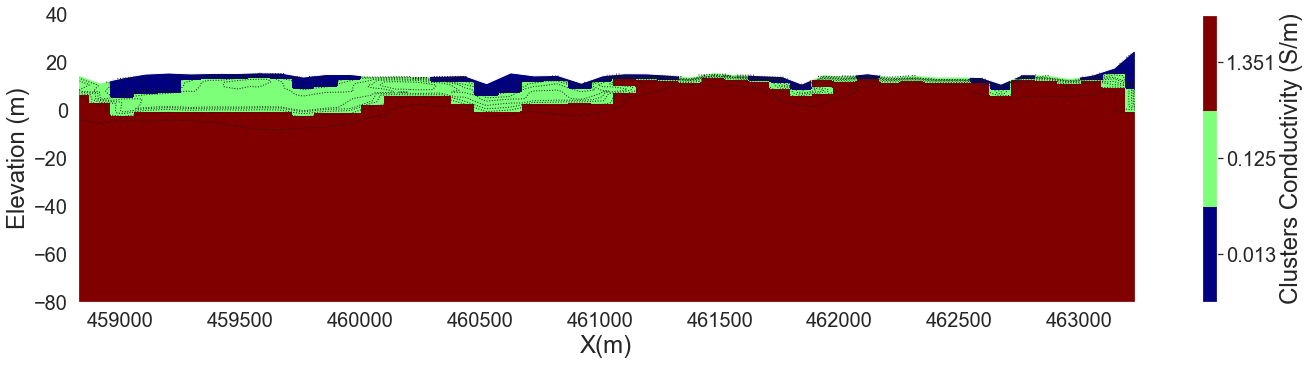

In [37]:
# Plot the cross-section of the quasi-geological model
fig,ax = plt.subplots(1,1,figsize=(20,5))
order_clusters_GM_mean(clfrecoverednogeo)
moptm_cond = mcluster_cond.reshape((hz.size, n_sounding), order='F')
mopt_petro_cond_xz = Utils.mkvc(moptm_cond[:,ind_line])
sigma_petro_cond = mapping * mcluster_cond
Sigma_petro_cond = sigma_petro_cond.reshape((hz.size, n_sounding), order='F')
sigma_xz_petro_cond = Utils.mkvc(Sigma_petro_cond[:,ind_line])

mm = plot2Ddata(
    xz, sigma_xz_petro_cond, scale='log',ax=ax,
    level=True, 
    ncontour=16,
    levelOpts={'colors':'k','linewidths':1, 'linestyles':'dotted'},
    clim=10.**(np.r_[-3,1]),
    mask=mask,
    nx=nx,
    ny=ny,
    contourOpts={'cmap':'viridis'},
    dataloc=False
)
mm =plot2Ddata_categorical(xz,
                     clfrecoverednogeo_cond.predict(np.log(sigma_xz_petro_cond)[:,np.newaxis]),ax=ax, scale='linear',
                      dataloc=False,
                      clim=[0.999,1.9999],
                     ncontour=0,
                           nx=nx,
                        ny=ny,
                     contourOpts={'cmap':'jet', },
)
plt.fill_between(topo[ind_line, 0], topo[ind_line, 2], topo[ind_line, 1]*0. + zmax, color='w')
plt.gca().set_aspect(10)
plt.gca().set_ylim([-80,40])
cb = plt.colorbar(mm[0], format='%.1e')
cb.set_ticks([0.5,1.5,1.99995])
cb.set_ticklabels([str(round(i[0],3)) for i in (10.**(np.log10(np.exp(clfrecoverednogeo_cond.means_))))])

cb.set_label('Clusters Conductivity (S/m)',fontsize=24)
cb.ax.tick_params(labelsize=20) 
plt.gca().tick_params(labelsize=20)
ax.set_xlabel('X(m)',fontsize=24)
ax.set_ylabel('Elevation (m)',fontsize=24)
plt.tight_layout()

#fig.savefig("Booky_petro3units_classification_cond_HighRes.png", dpi=600, bbox_inches='tight', pad_inches=0.1)
#fig.savefig("Booky_petro3units_classification_cond_LowRes.png", dpi=72, bbox_inches='tight', pad_inches=0.1)

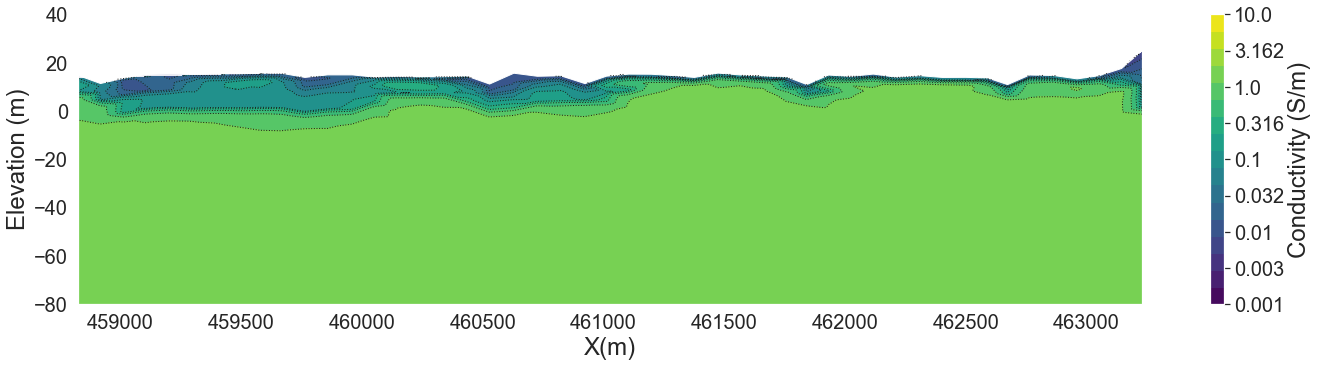

In [38]:
# Plot the cross-section of the PGI model, initial conductive model
fig,ax = plt.subplots(1,1,figsize=(20,5))
order_clusters_GM_mean(clfrecoverednogeo)
moptm_cond = mcluster_cond.reshape((hz.size, n_sounding), order='F')
mopt_petro_cond_xz = Utils.mkvc(moptm_cond[:,ind_line])
sigma_petro_cond = mapping * mcluster_cond
Sigma_petro_cond = sigma_petro_cond.reshape((hz.size, n_sounding), order='F')
sigma_xz_petro_cond = Utils.mkvc(Sigma_petro_cond[:,ind_line])

mm = plot2Ddata(
    xz, sigma_xz_petro_cond, scale='log',ax=ax,
    level=True, 
    ncontour=16,
    levelOpts={'colors':'k','linewidths':1, 'linestyles':'dotted'},
    clim=10.**(np.r_[-3,1]),
    mask=mask,
    nx=nx,
    ny=ny,
    contourOpts={'cmap':'viridis'},
    dataloc=False
)

plt.fill_between(topo[ind_line, 0], topo[ind_line, 2], topo[ind_line, 1]*0. + zmax, color='w')
plt.gca().set_aspect(10)
plt.gca().set_ylim([-80,40])
cb = plt.colorbar(mm[0], format='%.1e')
cb.set_ticks(np.linspace(-3,1.,9))
cb.set_ticklabels([str(round(i,3)) for i in (10.**np.linspace(-3,1,9))])

cb.set_label('Conductivity (S/m)',fontsize=24)
cb.ax.tick_params(labelsize=20) 
plt.gca().tick_params(labelsize=20)
ax.set_xlabel('X(m)',fontsize=24)
ax.set_ylabel('Elevation (m)',fontsize=24)
plt.tight_layout()

#fig.savefig("Booky_petro3units_cond_HighRes.png", dpi=600, bbox_inches='tight', pad_inches=0.1)
#fig.savefig("Booky_petro3units_cond_LowRes.png", dpi=72, bbox_inches='tight', pad_inches=0.1)

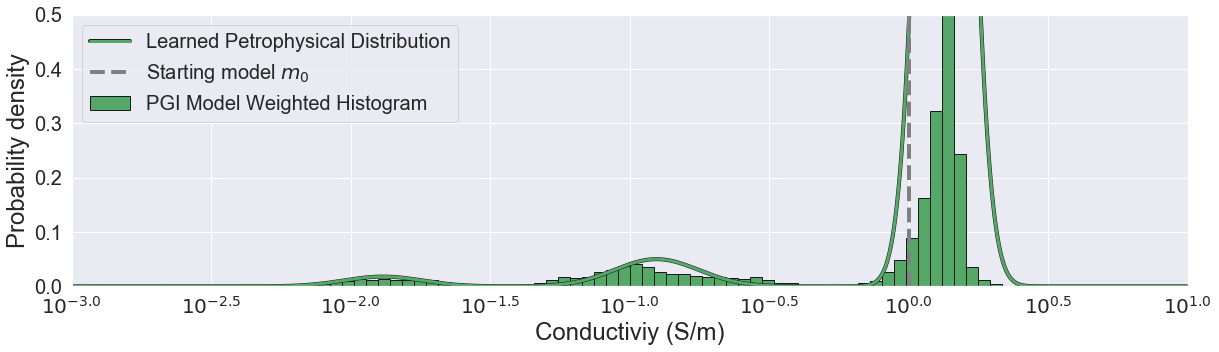

In [39]:
# Plot the learned petrophysical distribution and PGI model histogram, initial conductive background
m0 = np.ones_like(m0)*np.log(1.)
fig = plt.figure(figsize=(20,5))
hist, edges = np.histogram(mcluster_cond,bins=75, density=True,weights=mesh_reg.vol)
plt.gca().bar(np.log10(np.exp(edges[:-1])), hist, width=np.diff(np.log10(np.exp(edges))), ec="k", align="edge",
              label='PGI Model Weighted Histogram',color='g')
plt.plot(np.log10(np.exp(testXplot)),np.exp(clfrecoverednogeo_cond.score_samples(testXplot)),
         linewidth=3,c='g',
         label='Learned Petrophysical Distribution',
    path_effects=[pe.Stroke(linewidth=4, foreground='k'), pe.Normal()])
plt.gca().set_ylim([0.,0.5])
plt.gca().set_xlim([-3.,1.])
plt.gca().set_xlabel('Conductiviy (S/m)',fontsize=24)
plt.gca().set_ylabel('Probability density',fontsize=24)

plt.gca().tick_params(labelsize=20)
plt.gca().set_xticks([-3,-2.5,-2,-1.5,-1,-0.5,0,0.5,1])
plt.gca().xaxis.set_major_formatter(plt.FormatStrFormatter('$10^{%.1f}$'))
plt.gca().grid(b=True, which='minor', color='r', linestyle='--')
plt.gca().plot(np.log10(np.exp(np.unique(m0)))*np.ones(2),[0,5],linestyle='dashed',
               color='gray',linewidth=4,
              label='Starting model $m_0$')
plt.gca().legend(fontsize=20)
plt.show()

#fig.savefig("Booky_Hist_petro_cond_curves_HighRes.png", dpi=600, bbox_inches='tight', pad_inches=0.1)
#fig.savefig("Booky_Hist_petro_cond_curves_LowRes.png", dpi=72, bbox_inches='tight', pad_inches=0.1)